In [1]:
from dwave_networkx.algorithms.independent_set import maximum_weighted_independent_set_qubo
from DBK import *
import networkx as nx
import dwave_networkx as dnx
from dwave.system import DWaveCliqueSampler, DWaveSampler
from dwave.system import EmbeddingComposite
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import sys

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
sampler =  DWaveCliqueSampler()
sampler2 = EmbeddingComposite(DWaveSampler())

In [4]:
def draw_clique(G, pos, clique):
    color_map = ['green' if node in clique else 'grey' for node in G]
    node_dim = [3000 if node in clique else 1500 for node in G]
    edge_color_map = ['red' if edge[0] in clique and edge[1] in clique else 'black' for edge in G.edges()]
    edge_width = [4 if edge[0] in clique and edge[1] in clique else 1 for edge in G.edges()]        
    plt.figure(figsize=(40,40))
    nx.draw_networkx(G,pos, node_color=color_map, node_size=node_dim, edge_color=edge_color_map, width=edge_width, font_size=30) # node lables

In [6]:
def solver(g, qubo, ub, different_solver):
    response = sampler.sample_qubo(qubo, num_reads=1000)
    occurrences = []
    for occ in response:
        data = [node for node in occ if occ[node] > 0]
        if len(data)<=ub:
            occurrences.append(data)
    max_clique=[]
    max_len_clique=0
    for cli in occurrences:
        if dnx.is_clique(g, cli) and len(cli)>max_len_clique:
            max_len_clique=len(cli)
            max_clique=cli
    
    if max_len_clique==0 and different_solver==True:
        response = sampler2.sample_qubo(qubo, num_reads=1000)
        occurrences = []
        for occ in response:
            data = [node for node in occ if occ[node] > 0]
        if len(data)<=ub:
            occurrences.append(data)
        max_clique=[]
        max_len_clique=0
        for cli in occurrences:
            if dnx.is_clique(g, cli) and len(cli)>max_len_clique:
                max_len_clique=len(cli)
                max_clique=cli
        print("Used solver DwaveSalmpler")
        print("QUBO max clique size = ", max_len_clique)
        print("QUBO max clique = ", max_clique)
        return response, max_clique
    else:
        print("Used solver DwaveCliqueSalmpler")
        print("QUBO max clique size = ", max_len_clique)
        print("QUBO max clique = ", max_clique)
        return response, max_clique

In [7]:
def find_cliques_QUBO(g, try_different_solver):
    print("Graph with size ", len(g))
    ub = mc_upper_bound(g)
    print("MAX clique size = ", ub)
    complement_G = nx.complement(g)
                
    cost = dict(complement_G.nodes(data=None, default=1))
    scale = max(cost.values())
    qubo = {(node, node): min(-cost[node] / scale, 0.0) for node in complement_G}
    qubo.update({edge: 2.0 for edge in complement_G.edges()})
    response, max_cli = solver(g, qubo, ub, try_different_solver)
    print("Solution time: ", response.info["timing"]['qpu_anneal_time_per_sample']/1000, " ms")
                
    try:
        t=time.time()
        DBK_clique = DBK(g, ub, nx.max_weight_clique)
        elapsed=time.time()-t
        print("DBK solution time = ", elapsed*1000, " ms")
        print("DBK max clique size = ", len(DBK_clique))
        print("DBK max clique = ", DBK_clique)
    except:
        print("DBK error")

    print("\n")
    return max_cli

# Gaussian

In [28]:
G = nx.gaussian_random_partition_graph(50, 20, 5, 0.3, 0.2, directed=False)
pos = nx.spring_layout(G, seed=3113794652)
ub= mc_upper_bound(G)
print(ub)

7


In [32]:
x = list(G.nodes())
for i in x:
    g = G.copy()
    g.remove_node(i)
    new_ub = mc_upper_bound(g)
    if new_ub == ub:
        G.remove_node(i)
print(mc_upper_bound(G))

7


In [31]:
find_cliques_QUBO(G, True)

Graph with size  29
MAX clique size =  7
Used solver DwaveCliqueSalmpler
QUBO max clique size =  4
QUBO max clique =  [23, 26, 38, 45]
Solution time:  0.02  ms
DBK solution time =  4.999876022338867  ms
DBK max clique size =  4
DBK max clique =  [17, 27, 39, 16]




[23, 26, 38, 45]

# Tree

In [201]:
G = nx.turan_graph(20, 6)
ub = mc_upper_bound(G)
print(ub)

6


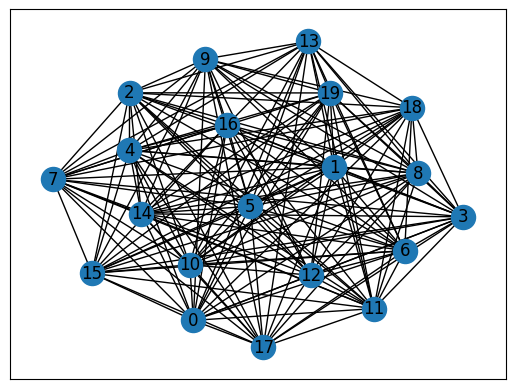

In [229]:
nx.draw_networkx(G)

In [70]:
clique = find_cliques_QUBO(G, True)

Graph with size  169
MAX clique size =  10
Used solver DwaveCliqueSalmpler
QUBO max clique size =  4
QUBO max clique =  [35, 83, 84, 117]
Solution time:  0.02  ms
DBK solution time =  440.99998474121094  ms
DBK max clique size =  10
DBK max clique =  [24, 34, 85, 124, 145, 10, 162, 101, 59, 69]




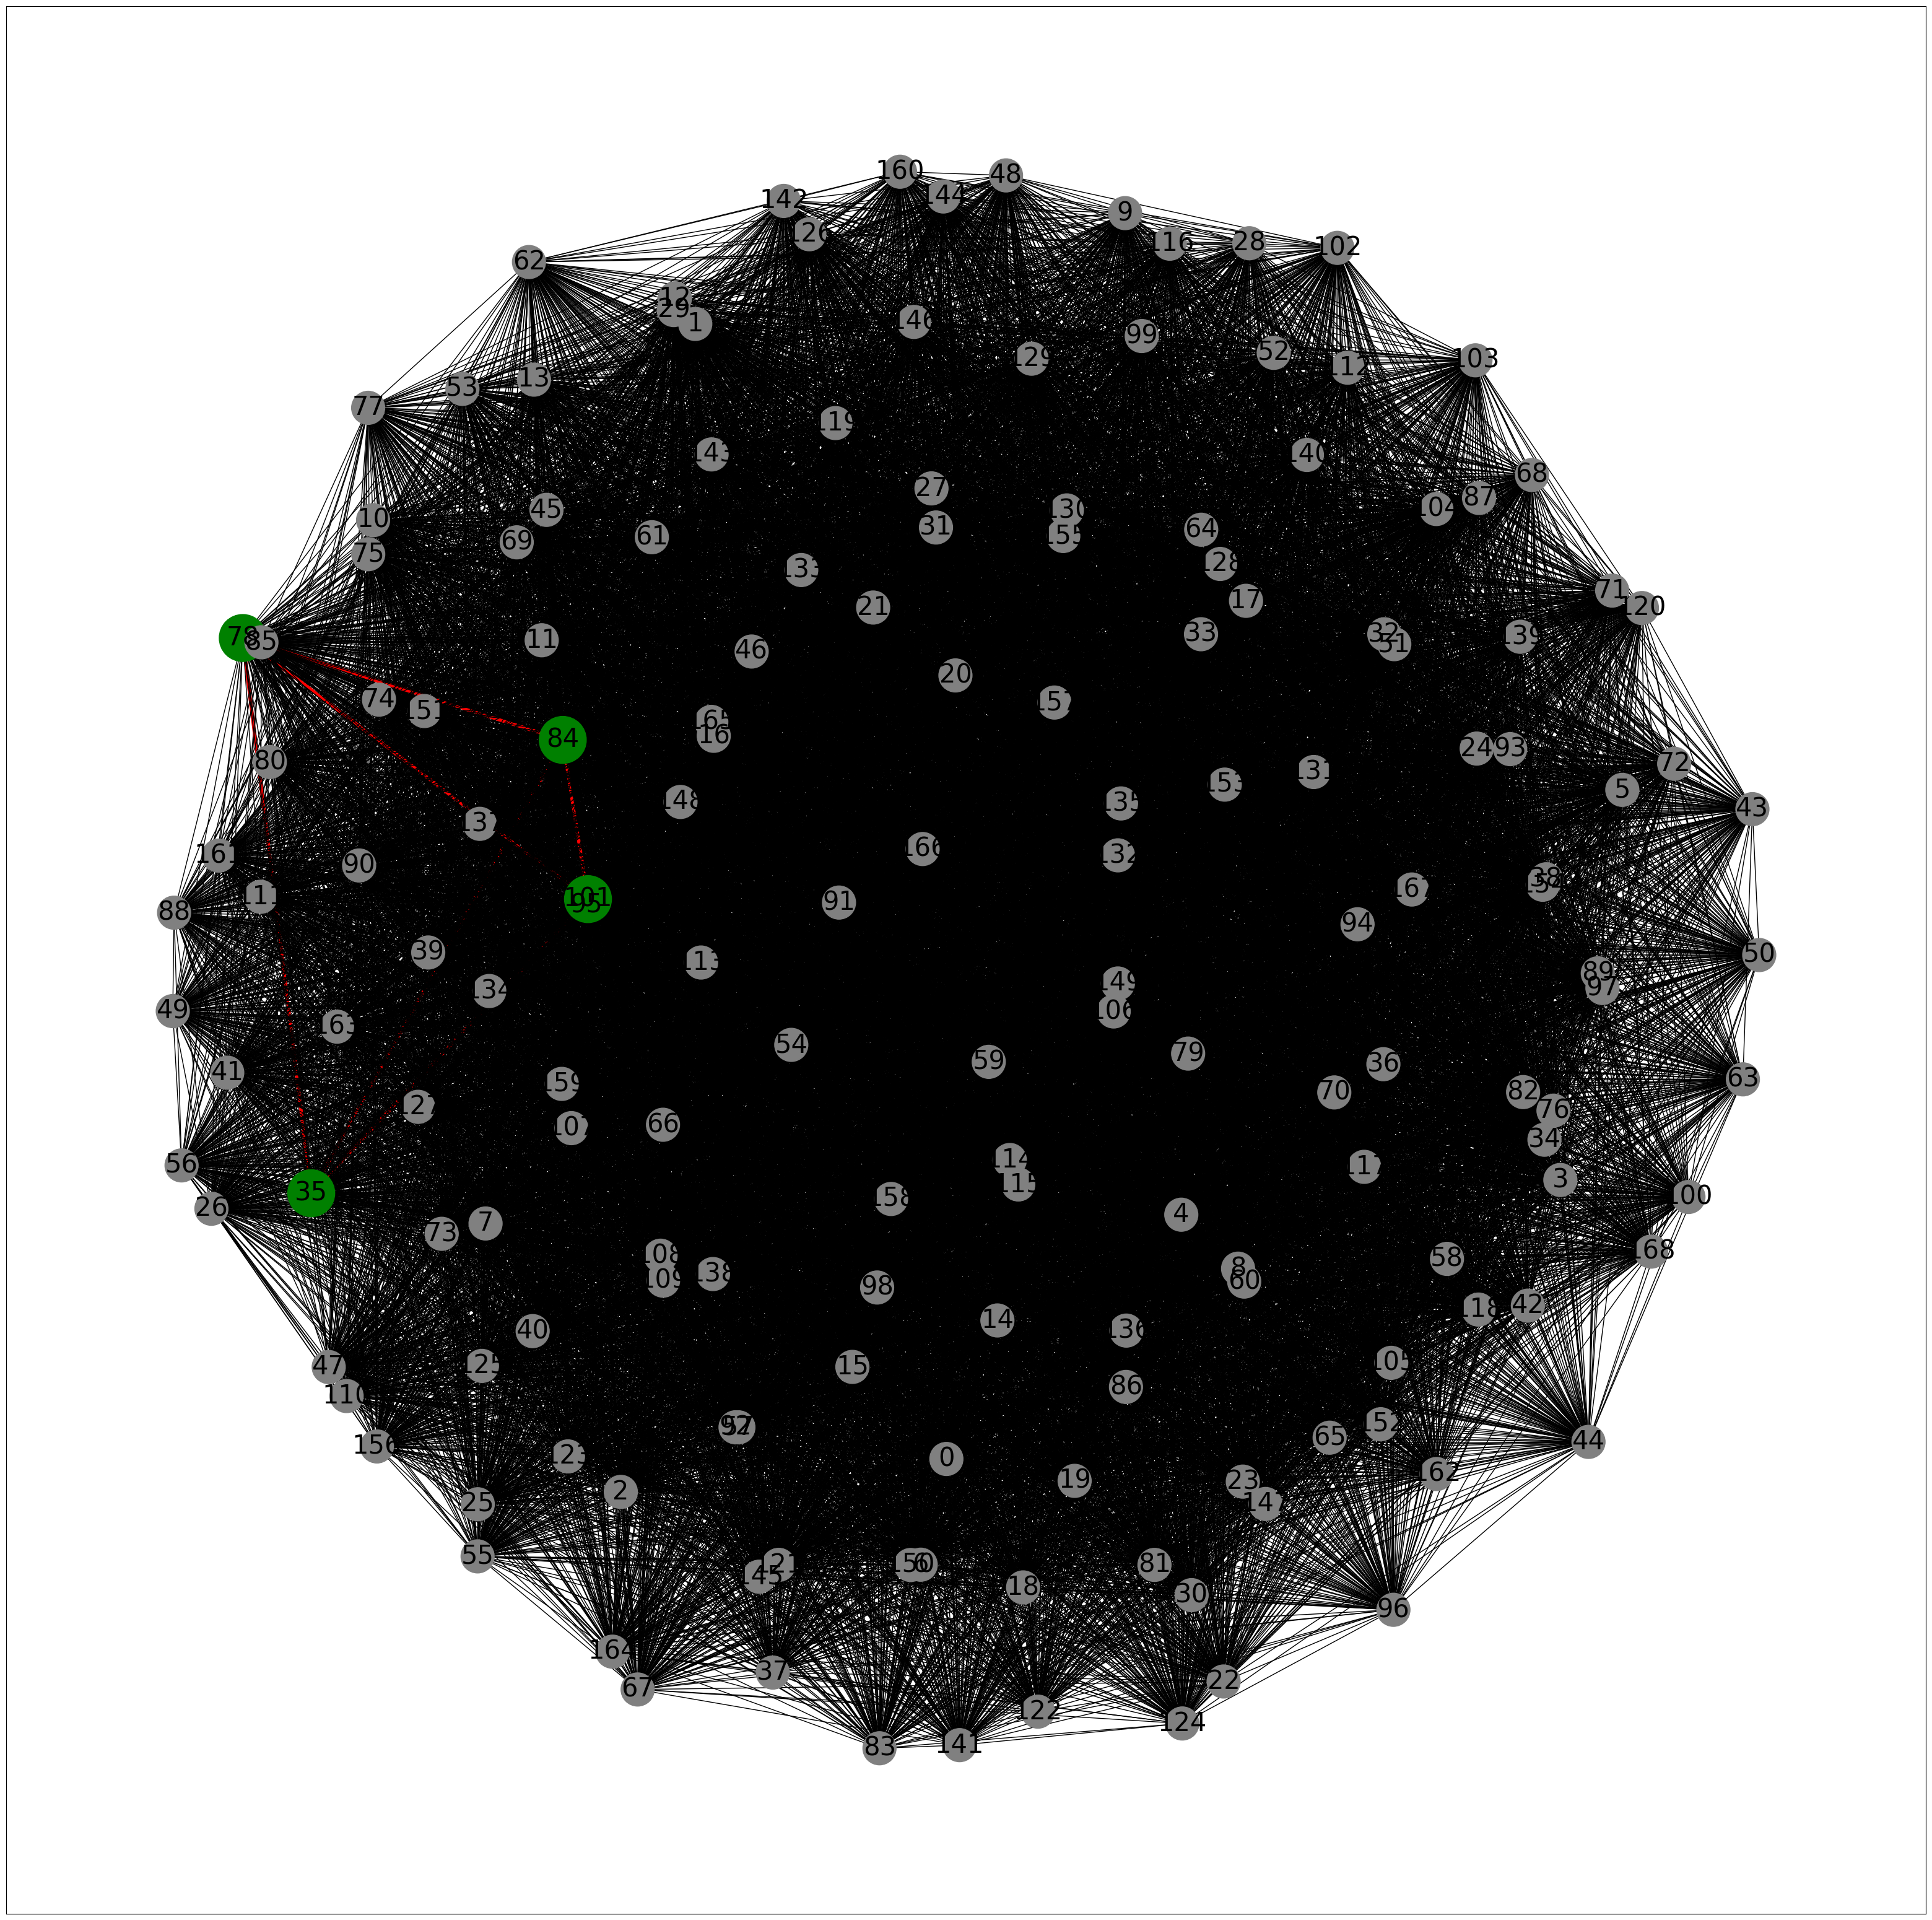

In [68]:
draw_clique(G, nx.spring_layout(G), clique)

# Graph decomposition

In [7]:
from random import choice, sample

In [46]:
G = nx.gaussian_random_partition_graph(200, 30, 2, 0.2, 0.2, directed=False)
ub = mc_upper_bound(G)
ub

15

In [47]:
def check_proximity_and_equality(a,b,c,g):
    if a!=b and a!=c and c!=b:
        if (a,b) in g.edges() and (b,c) in g.edges() and (c,a) not in g.edges():
            return True
        elif (a,b) in g.edges() and (a,c) in g.edges() and (b,c) not in g.edges():
            return True
        elif (a,c) in g.edges() and (b,c) in g.edges() and (a,b) not in g.edges():
            return True
        else:
            return False
    else:
        return False
def center_vertex(a,b,c,g):
    if (a,b) in g.edges() and (b,c) in g.edges() and (c,a) not in g.edges():
        return b
    elif (a,b) in g.edges() and (a,c) in g.edges() and (b,c) not in g.edges():
        return a
    else:
        return c

In [48]:
def decomposite_graph(g, times):
   used_vertex = []
   for i in range(times):    
      a = choice(list(g.nodes()))
      b = choice(list(g.nodes()))
      c = choice(list(g.nodes()))
      count = 0
      is_in_list = True
      while not check_proximity_and_equality(a,b,c,g) and is_in_list: 
         a = choice(list(g.nodes()))
         b = choice(list(g.nodes()))
         c = choice(list(g.nodes()))
         center= center_vertex(a,b,c,g)
         is_in_list = center in used_vertex
         count=count+1
         if count == 100:
            break
      if count<100:
         center = center_vertex(a,b,c,g)
         used_vertex.append(center)
         neighbour = [n for n in g.neighbors(center)]
         for v in neighbour:
            used_vertex.append(v)
         g.remove_node(center)
         print("removed ", center)
   return(g)


In [49]:
complement_G=nx.complement(G)

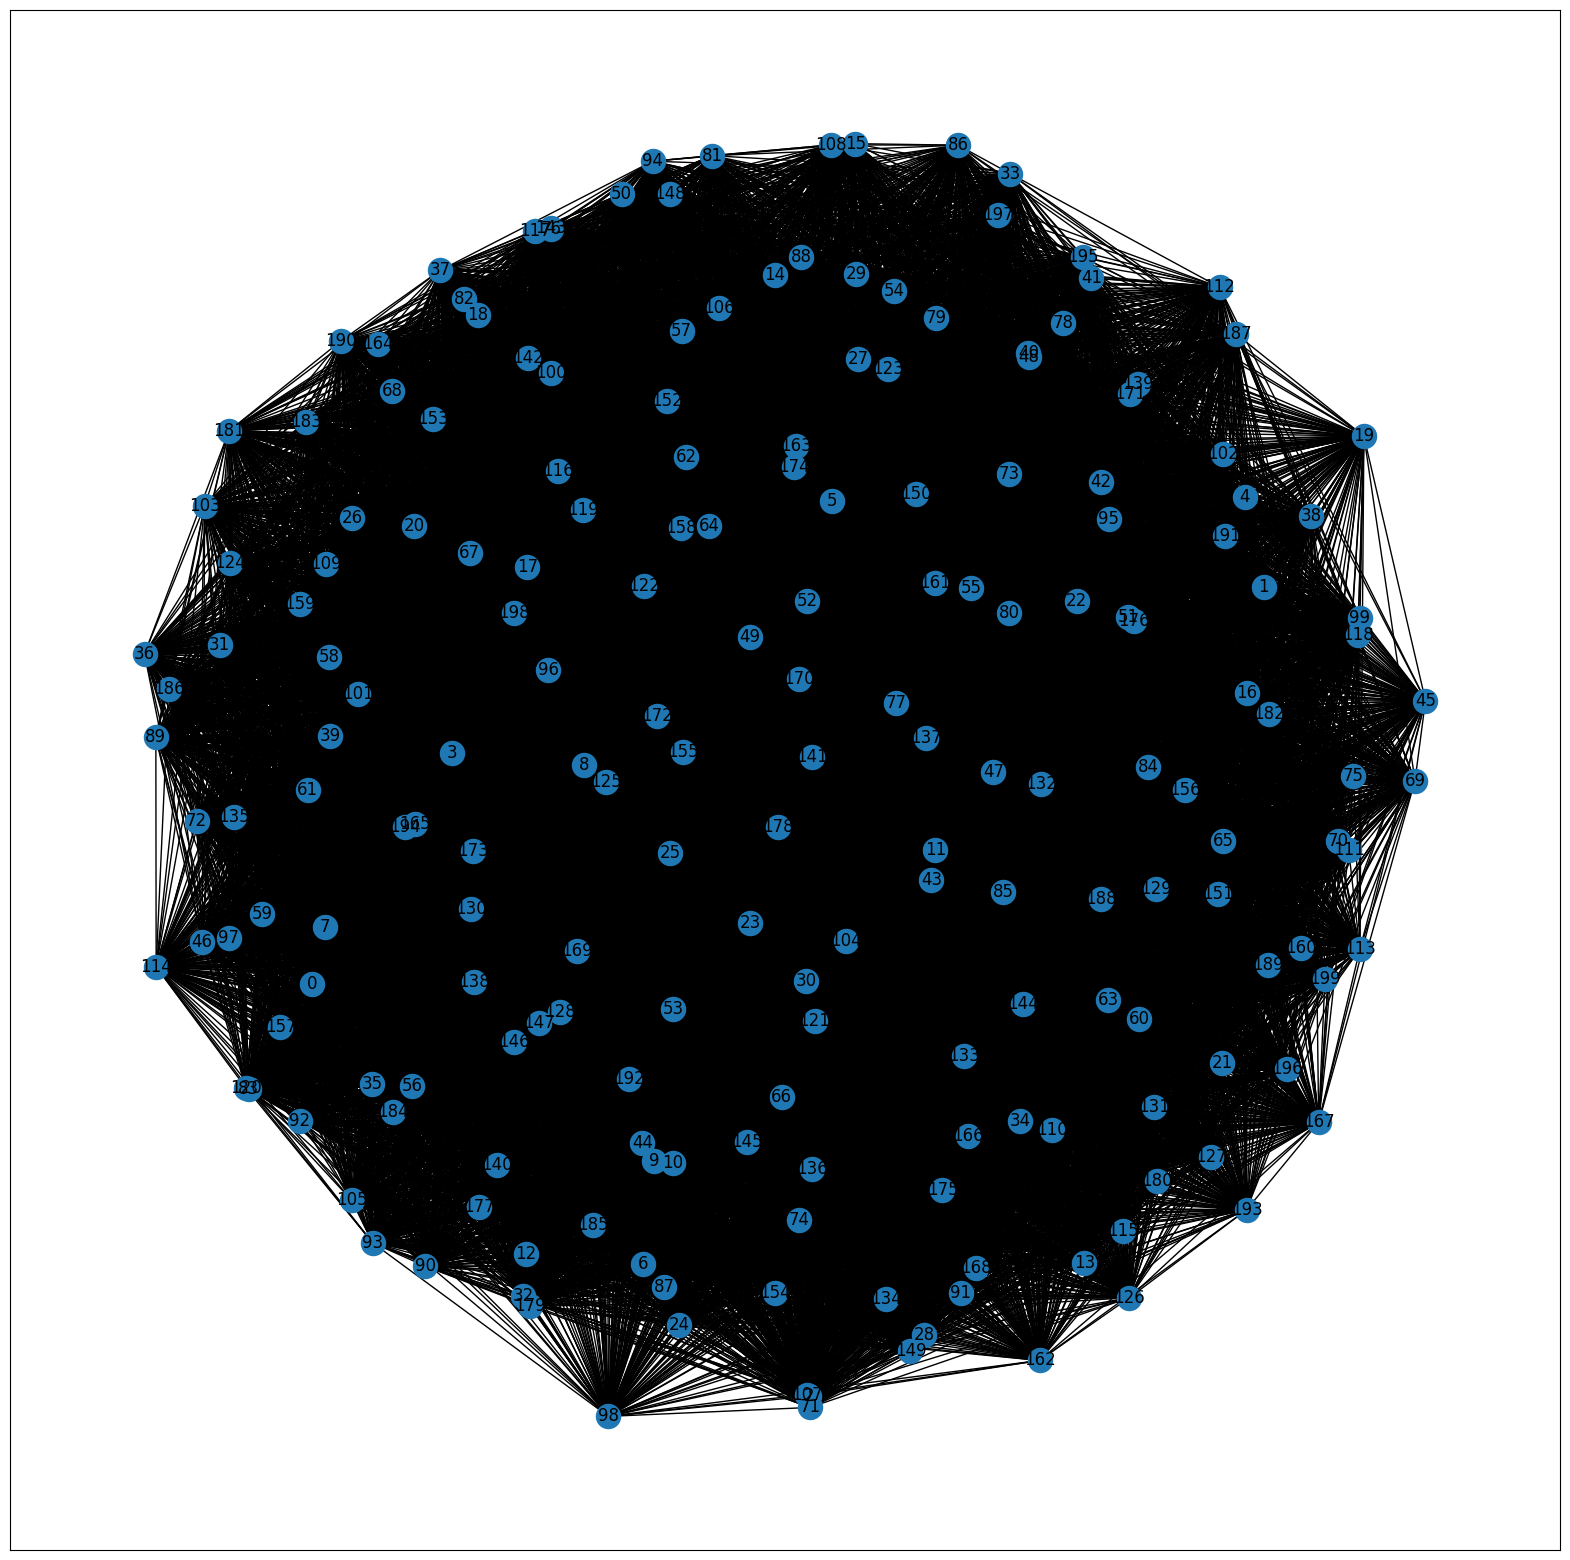

In [50]:
pos = nx.spring_layout(complement_G)
plt.figure(figsize=(20,20))
nx.draw_networkx(complement_G, pos)

In [54]:
complement_G = decomposite_graph(complement_G, 120)

removed  124
removed  88
removed  112
removed  28
removed  98
removed  195
removed  191
removed  49
removed  86
removed  1
removed  27
removed  184
removed  182
removed  158
removed  130
removed  101
removed  143
removed  129
removed  26
removed  132
removed  18
removed  90
removed  54
removed  169
removed  56
removed  131
removed  137
removed  177
removed  76
removed  11
removed  7
removed  55
removed  99
removed  163
removed  138
removed  183
removed  78
removed  63
removed  20
removed  39
removed  126
removed  92
removed  199
removed  81
removed  121
removed  152
removed  73
removed  194
removed  115
removed  23
removed  146
removed  41
removed  148
removed  10
removed  170
removed  144
removed  72
removed  142
removed  120
removed  164
removed  85
removed  36
removed  189
removed  140
removed  196
removed  43
removed  123
removed  62
removed  134
removed  69
removed  181
removed  108
removed  22
removed  0
removed  119
removed  174
removed  192
removed  188
removed  178
removed  17

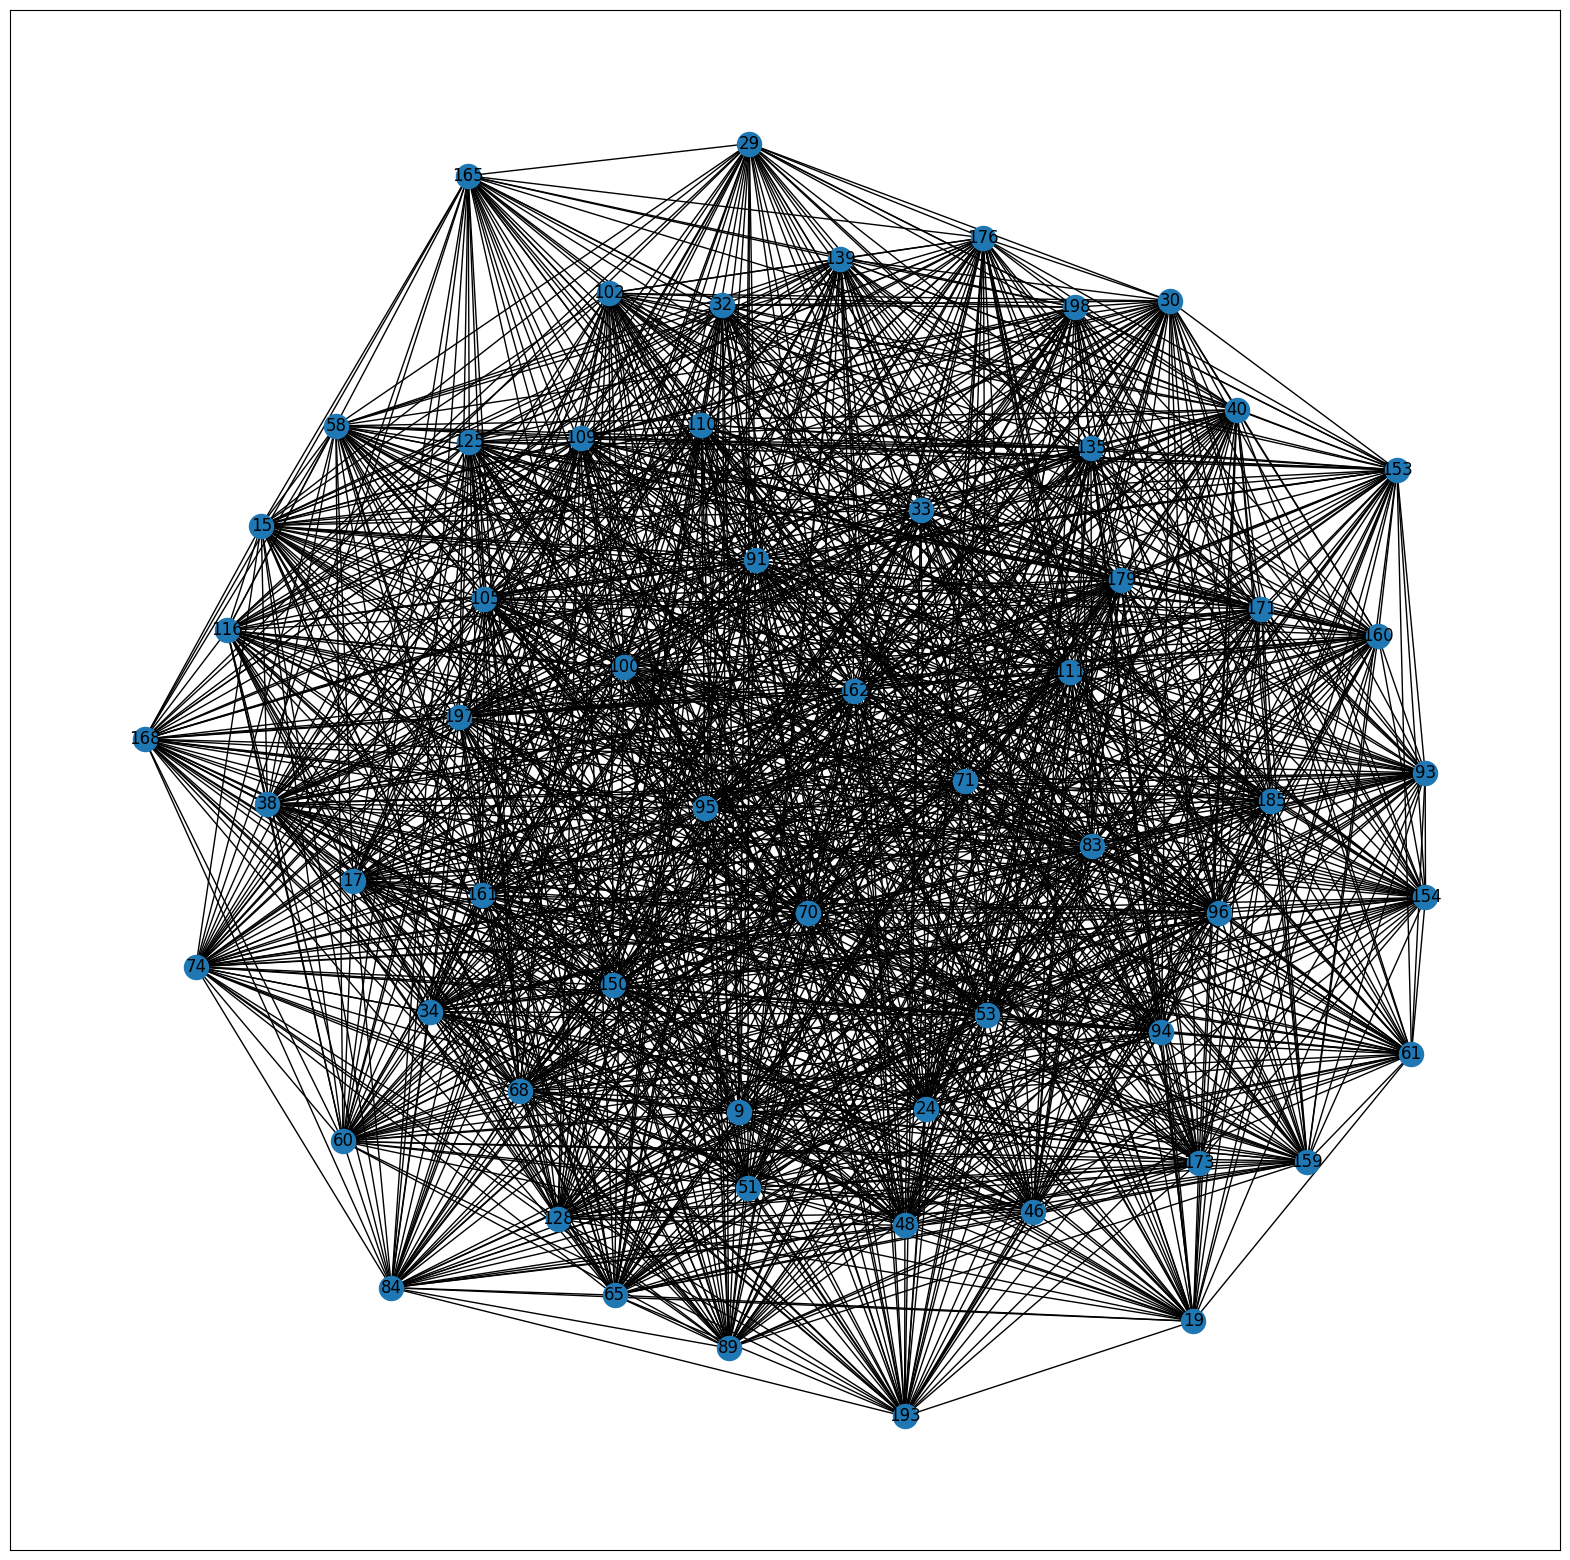

In [55]:
plt.figure(figsize=(20,20))
nx.draw_networkx(complement_G)

In [56]:
len(complement_G)

60

In [57]:
find_cliques_QUBO(nx.complement(complement_G), True)

Graph with size  60
MAX clique size =  7
Used solver DwaveSalmpler
QUBO max clique size =  0
QUBO max clique =  []
Solution time:  0.02  ms
DBK solution time =  3.999471664428711  ms
DBK max clique size =  4
DBK max clique =  [135, 74, 61, 9]




[]

# Altro

In [165]:
complement_G= nx.complement(G)

In [166]:
cost = dict(complement_G.nodes(data=None, default=1))
scale = max(cost.values())
Q = {(node, node): min(-cost[node] / scale, 0.0) for node in complement_G}
Q.update({edge: 2.0 for edge in complement_G.edges()})
#Q.update({n_edge: 0.5 for n_edge in list(nx.non_edges(complement_G))})

In [167]:
def q_to_matrix(qubo, dim):
    mat = np.zeros((dim,dim))
    for i in qubo.keys():
        mat[i[0],i[1]] = qubo[(i[0], i[1])]
    return mat

In [168]:
m = q_to_matrix(Q, len(complement_G.nodes()))

In [106]:
y = []
x = []
schedule= []
for i in range(0, 11, 1):
    y.append(i/10)
    j = i*i
    x.append(j+1000)
    schedule.append([j,(i/10)])

In [169]:
#response = DWaveCliqueSampler().sample_qubo(Q, num_reads=1000)
response = sampler2.sample_qubo(Q, num_reads=1000)

In [170]:
samplest_greedy = sampler_greedy.sample_qubo(Q, num_reads=1000, initial_state=response)

In [171]:
occurrences = []
for i in response:
    data = [node for node in i if i[node] > 0]
    if len(data)<=ub:
        occurrences.append(data)
cliques = []
for i in range(len(occurrences)):
    if dnx.is_clique(G, occurrences[i]):
        cliques.append(occurrences[i])

In [172]:
len(cliques)

1

In [173]:
occurrences = []
for i in samplest_greedy:
    data = [node for node in i if i[node] > 0]
    if len(data)<=ub:
        occurrences.append(data)

In [174]:
uniq = []
for i in cliques:
    if not i in uniq:
        uniq.append(i)

In [175]:
cliques = []
for i in range(len(uniq)):
    if dnx.is_clique(G, uniq[i]):
        cliques.append(uniq[i])

In [176]:
len(cliques)

1

In [177]:
occurrences = []
for i in response:
    data = [node for node in i if i[node] > 0]
    if len(data)<=ub:
        occurrences.append(data)
cliques = []
for i in range(len(occurrences)):
    if dnx.is_clique(G, occurrences[i]):
        cliques.append(occurrences[i])

In [178]:
cliques[0]

[0, 1, 2]

<Figure size 640x480 with 0 Axes>

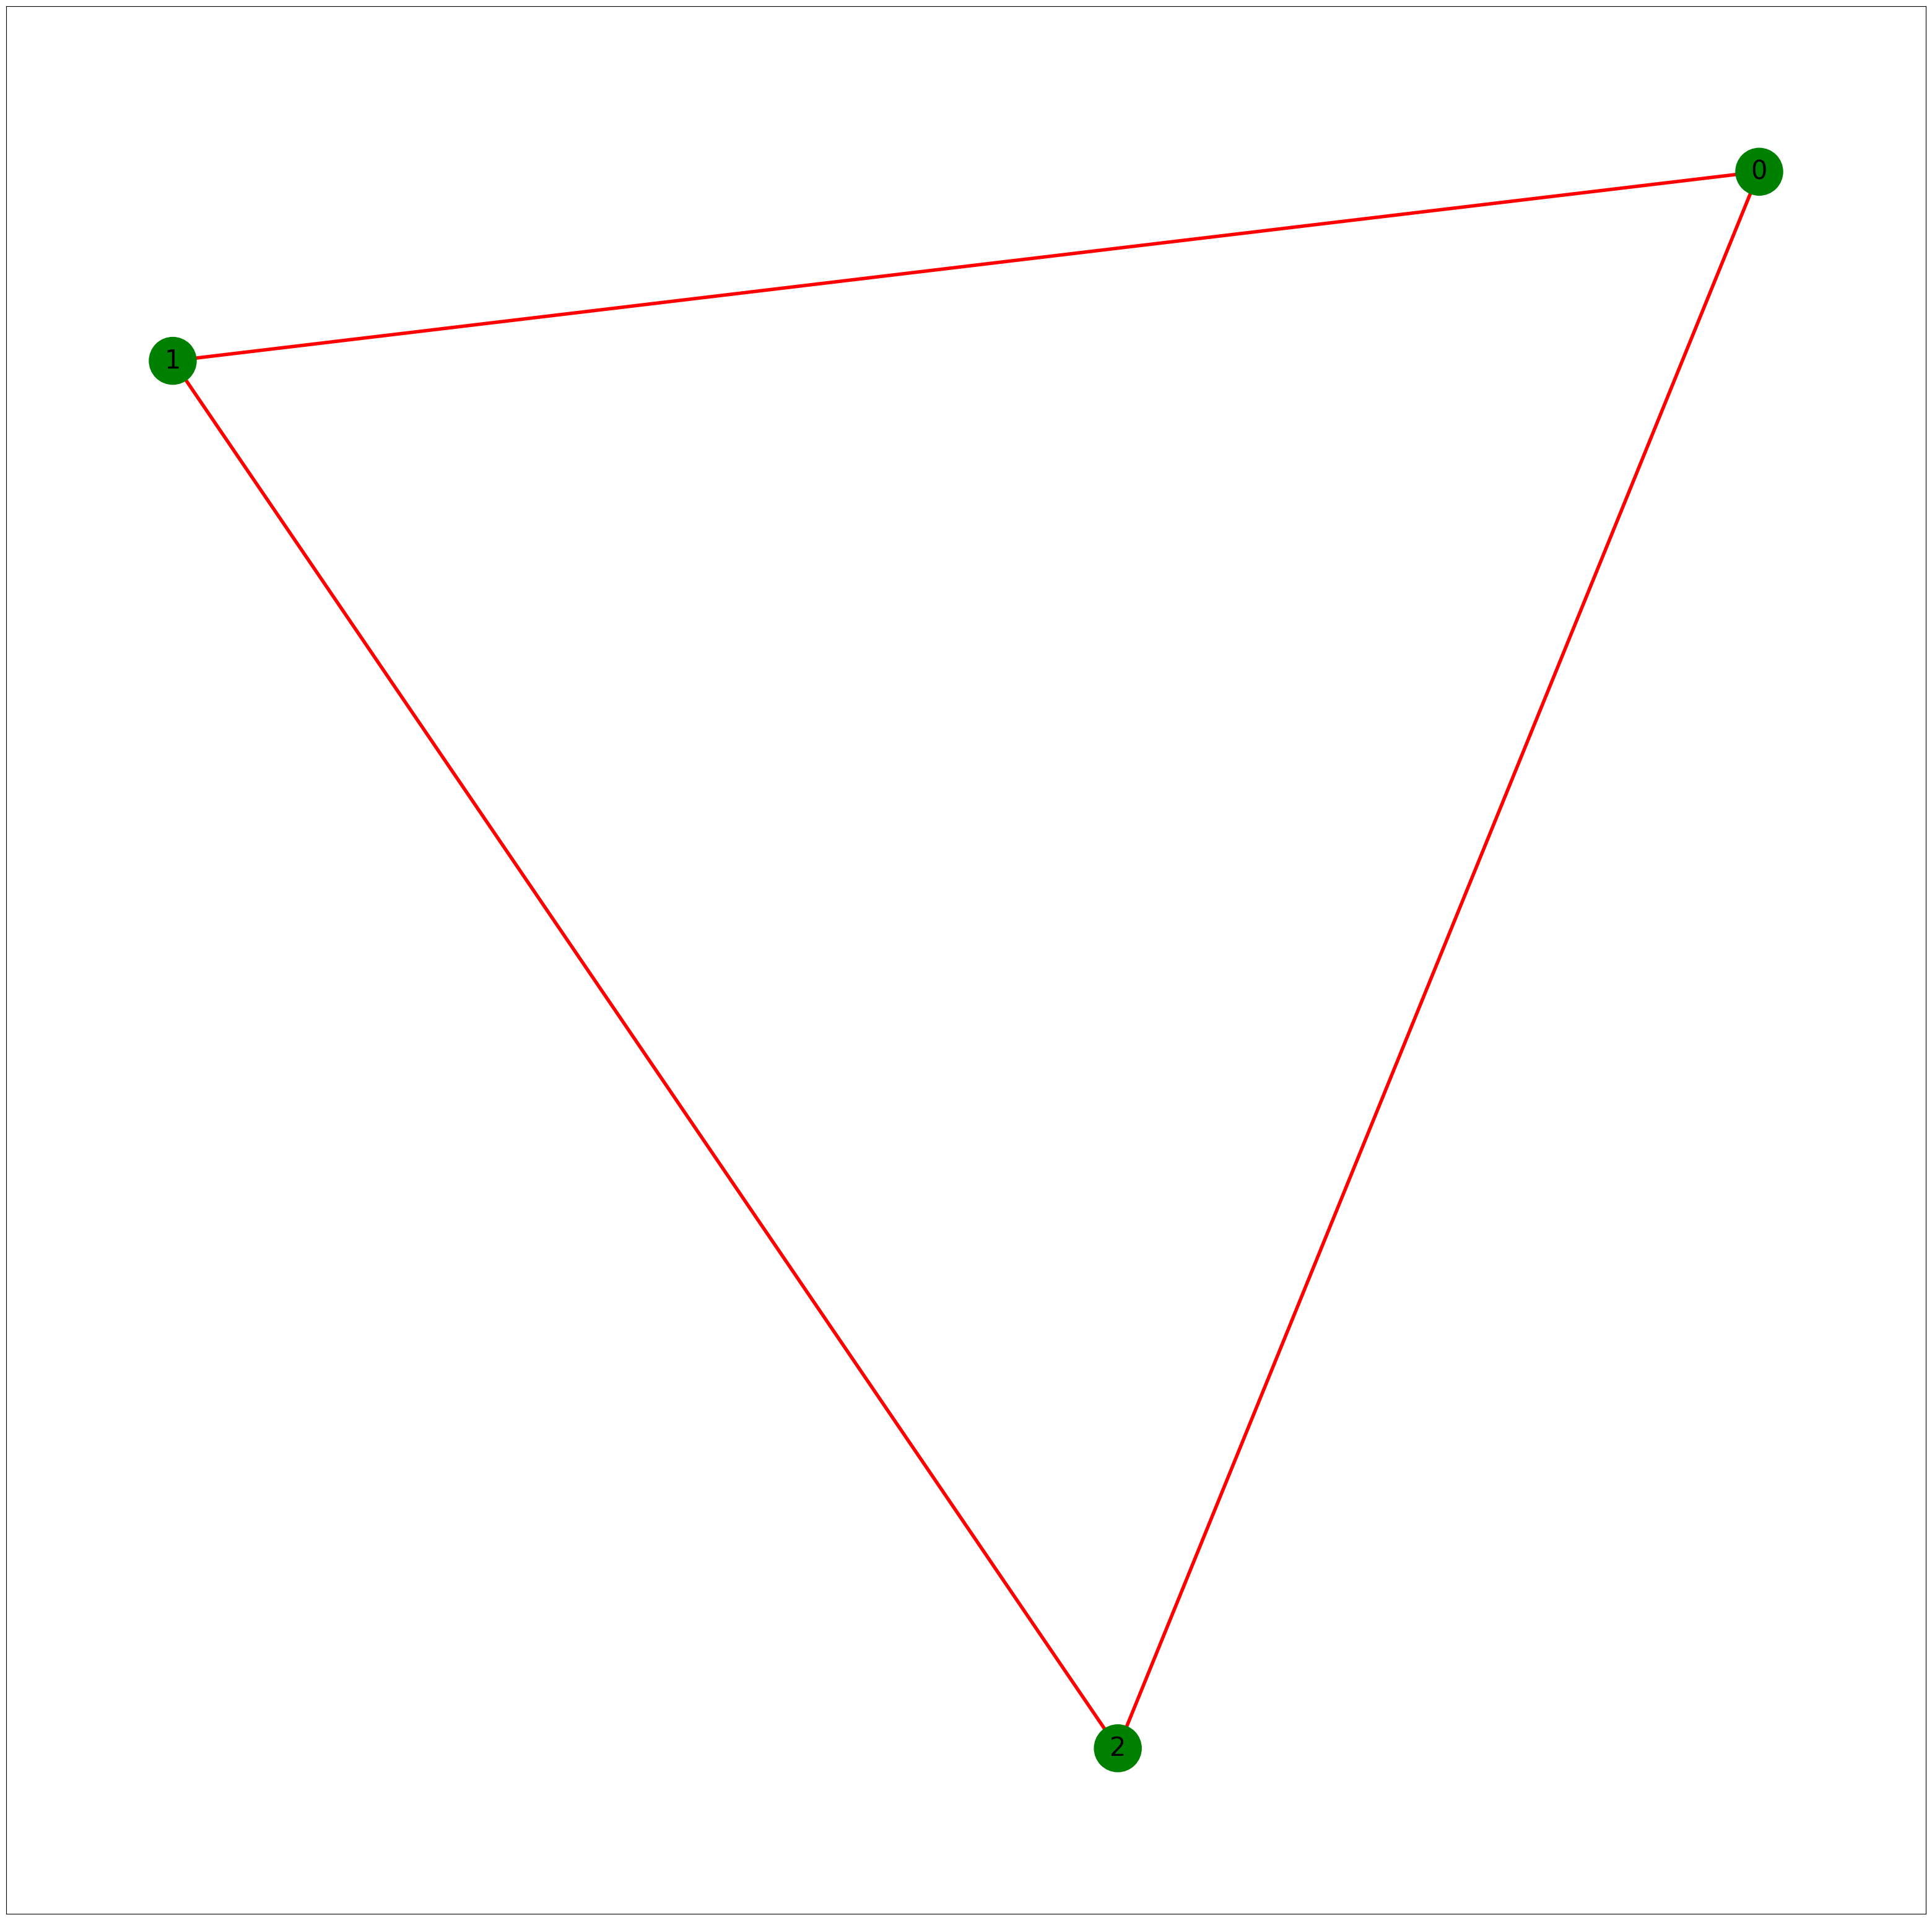

In [180]:
for i in range(1):
    plt.figure(i)
    draw_clique(G, pos, cliques[i])